# Multi-class Classification

#### AI Saturday Lagos Begineers Class (Instructors: `Tejumade Afonja`, `Kenechi Dukor`, `Ifeanyi Igwegbe`)
This exercise is adopted from [Andrew Ng Machine Learning Course](https://www.coursera.org/learn/machine-learning)

In this notebook, we will be exploring multi-class classification. We will be using the popular hand written digit dataset.
Dont be scared, it is similar to what we had done previously.

## Using Logistic Regression

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat # Used to load the MATLAB *.mat files
import random # To pick random images to display

### Loading Data

The dataset ex3data1.mat, contains 5000 training examples of handwritten digits.
The .mat format means that that the data has been saved in a native MATLAB matrix format, instead of a text (ASCII) format like a csv-ﬁle. 

These matrices can be read directly into your program by using the load command. 

In [4]:
datafile = 'data/ex3data1.mat'
data = loadmat( datafile )
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

We notice that the `X` and `y` values are saved in a dictionary. We can therefore access the keys

In [5]:
X_, y = data['X'], data['y']
print(X_.shape,y.shape)

(5000, 400) (5000, 1)


- X_ contains 5000 images. Each image is a row of pixel values. Each image is 20 x20 pixels, and has been unrolled to become 400 x 1 pixels. This means that each pixel is a feature fed into our model
- y is a classification for each image. 1-10, where "10" is the handwritten "0"

### Visualize Data

In [6]:
import matplotlib.gridspec as gridspec

In [7]:
M = X_.shape[0] # = 5000 pixels per sample
N = X_.shape[1] # = 400 samples
dim = len(np.unique(y)) # = 10 distinct classes for this example.

examples = X_[np.random.randint(M, size = dim * dim)] # pick random row, which is an unrolled image.
examples.shape

(100, 400)

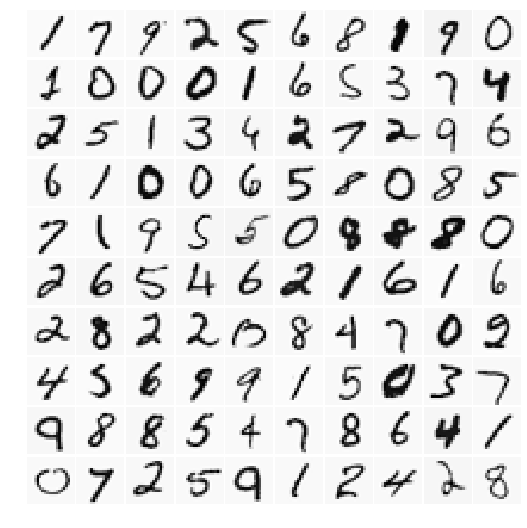

In [8]:
fig = plt.figure(figsize=(7, 7))

gs = gridspec.GridSpec(dim, dim)
gs.update(bottom=0.01, top=0.99, left=0.01, right=0.99, 
          hspace=0.05, wspace=0.05)

k = 0
for i in range(dim):
    for j in range(dim):
        ax = plt.subplot(gs[i, j])
        ax.axis('off')
        ax.imshow(examples[k].reshape(int(np.sqrt(N)), int(np.sqrt(N))).T,
            cmap=plt.get_cmap('Greys'), interpolation='nearest')
        k += 1

Now, lets stackout column of ones as we have always done.

Another method that can be used to stack a a column of ones is `X = np.insert(X,0,1,axis=1)`.
Recall that in the previous lecture, we explained how you could use `hstack` to perform the same function

In [9]:
#Insert a column of 1's to X
X = np.c_[np.ones(X_.shape[0]), X_]
X

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

## Implementation

### Sigmoid function

Now, lets implement the sigmoid function that we discussed in class. 
Remember that we modified the hypothesis for logistic regression as follows:

$$h_\theta(x) = g(\theta^Tx)$$

where $g$ is the sigmoid function defined as:
$$g(z) = \frac{1}{1+e^{-z}}$$


In [10]:
def sigmoid(z):
    return(1 / (1 + np.exp(-z)))

### Cost Function

Now lets implement the cost function that we also discussed in class.

$$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$

where the cost 
- `J = -log(h) when y = 1`
- `J = -log(1 - h) when y = 0`

In [11]:
def Cost(theta, X, y, reg):
    m = y.size
    
    h = sigmoid(X @ theta)
    
    J = -1*(1/m)*(np.log(h).T @ y + np.log(1-h).T @ (1-y)) + (reg/(2*m))*np.sum(np.square(theta[1:]))
    
    return(J[0])

### Gradient

Recall that the gradient of the regularized cost function is given as:
$$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} + \frac{\lambda}{m}\theta_{j}$$ 

In [15]:
def gradientReg(theta, X, y, reg):
    m = y.size
    
    h = sigmoid(X @ theta.reshape(-1,1))
    
    #regularization skips the first element in theta
    grad = ((1/m) * X.T) @ (h-y) + (reg/m)*np.r_[[[0]],theta[1:].reshape(-1,1)]
    
    return(grad.flatten())

Now, lets test our functions with an initialized weight of zeros.

In [17]:
# testing with reg = 1
theta_initial = np.zeros(X.shape[1])
print(theta_initial.shape, X.shape)
Cost(theta_initial, X, y, 1)
# gradientReg(theta_initial, X, y, 1)

(401,) (5000, 401)


160.39425758157174

Lets also check if the `scipy` optimization function works fine

In [18]:

from scipy.optimize import minimize
# reg = 0
res1 = minimize(Cost, theta_initial, args=(X, y, 1), method=None, jac=gradientReg, options={'maxiter':500})
res1

      fun: 160.39425758157174
 hess_inv: array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])
      jac: array([-5.00000000e+00,  0.00000000e+00,  0.00000000e+00, -7.74530186e-08,
        3.19876600e-06,  1.89536237e-05, -7.06376094e-04, -8.97395355e-04,
       -3.72741263e-04, -1.10787541e-04, -1.37049401e-04, -4.11905416e-05,
        3.09307938e-05,  7.56273049e-05,  1.66101324e-04,  1.88959823e-04,
        1.11618541e-04,  3.44740605e-05,  2.31849497e-07, -3.65944989e-07,
        0.00000000e+00, -2.71480120e-07,  2.68348312e-06,  1.35802658e-06,
        5.10971729e-05,  9.29459372e-05, -1.13518367e-03, -4.04630781e-03,
       -5.65616107e-03, -4.38249876e-03, -1.22936584e-03,  1.06402725e-03,
        1.67724463e-03,  1.83122226e-03,  1.41359436e-03,  1.00669534e-03,
        6.22600175e-04,  2.88468971e-04,  1.69300222e-04,  4.5332856

### One vs All Classification
Unlike in the previous lecture where we only had two classes of output which is either `0` or `1`, here we have 10 classes which are `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.

We will be using the idea of one hot encoding, a.k.a **one vs all**.

This means that when we are prediction for `0`, we will have an array like this `[[1], [0], [0], [0], [0], [0], [0], [0], [0], [0]]`.

When the predicition is `1`, `[[0], [1], [0], [0], [0], [0], [0], [0], [0], [0]]`

When the predicition is `2`, `[[0], [0], [1], [0], [0], [0], [0], [0], [0], [0]]`

When the predicition is `3`, `[[0], [0], [0], [1], [0], [0], [0], [0], [0], [0]]`

When the predicition is `4`, `[[0], [0], [0], [0], [1], [0], [0], [0], [0], [0]]`

When the predicition is `5`, `[[0], [0], [0], [0], [0], [1], [0], [0], [0], [0]]`, and so on

In [19]:
def OneVsAll(features, classes):
    n_labels = 10 # ten classes
    reg = 1 # regularisation
    
    all_theta = np.zeros((n_labels, X.shape[1])) #10x401

    for c in np.arange(1, n_labels+1):
        res = minimize(Cost, theta_initial, args=(features, (classes == c)*1, reg), method=None,
                       jac=gradientReg, options={'maxiter':50})
        all_theta[c-1] = res.x
    return(all_theta)

In [20]:
theta = OneVsAll(X, y)
theta

array([[-1.51180119e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.02827866e-04,  1.06348556e-07,  0.00000000e+00],
       [-2.79007877e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.29642602e-03, -1.47959330e-04,  0.00000000e+00],
       [-4.17892362e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.43381890e-05,  2.57040938e-07,  0.00000000e+00],
       ...,
       [-7.52116863e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -6.15634678e-05,  5.60274904e-06,  0.00000000e+00],
       [-4.28949902e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.25938941e-04,  5.21265716e-06,  0.00000000e+00],
       [-3.13839609e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.53313156e-04,  7.55661429e-06,  0.00000000e+00]])

### Prediction

Lets see how well the model does at prediction

In [21]:
def predictOneVsAll(all_theta, features):
    # all_theta.T need to be transposed first!
    probs = sigmoid(X @ all_theta.T)
    print(probs[0])
    # Adding one because Python uses zero based indexing for the 10 columns (0-9),
    # while the 10 classes are numbered from 1 to 10.
    return(np.argmax(probs, axis=1)+1)

In [22]:
pred = predictOneVsAll(theta, X)
print(pred)
print('Training set accuracy: {} %'.format(np.mean(pred == y.ravel())*100))

[1.49996209e-09 4.75730970e-04 1.02125501e-04 7.04369141e-08
 6.25965379e-04 4.00922805e-05 3.54445764e-04 5.64179039e-05
 7.29221125e-04 9.97616146e-01]
[10 10 10 ...  9  9  7]
Training set accuracy: 93.16 %


#### Lets see a sample of all the digits that where classified correctly

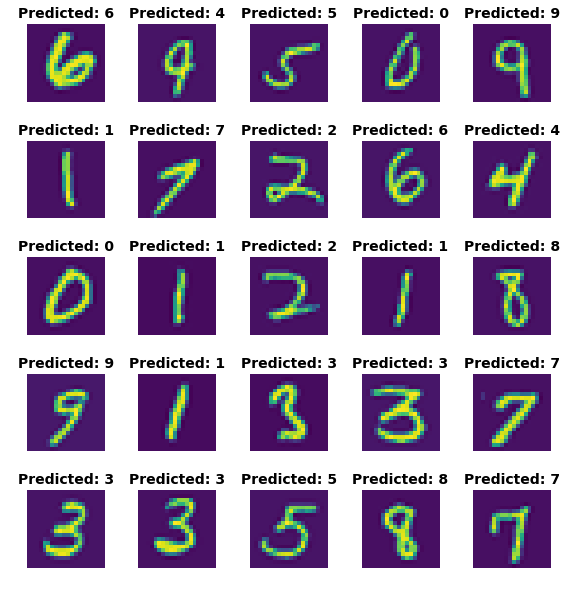

In [23]:
n_cols = 5 
n_rows = 5
pix = 20
fig,axs = plt.subplots(n_rows,n_cols, figsize=(10,10))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i in range(n_cols*n_rows):
    sample = np.random.choice(X.shape[0],1)
    a = data['X'][sample].reshape(-1,pix).T
    plt.imshow(a)
    def display_predict():
        predicted_val = pred[sample]
        if predicted_val != 10:
            return predicted_val
        else:
            return 0
    predicted_val = display_predict()
    axs[i].axis('off')
    axs[i].set_title('Predicted: %d'%predicted_val, fontsize=14, fontweight='bold')
    axs[i].imshow(a)

#### Lets see a sample of all the digits that where classified incorrectly

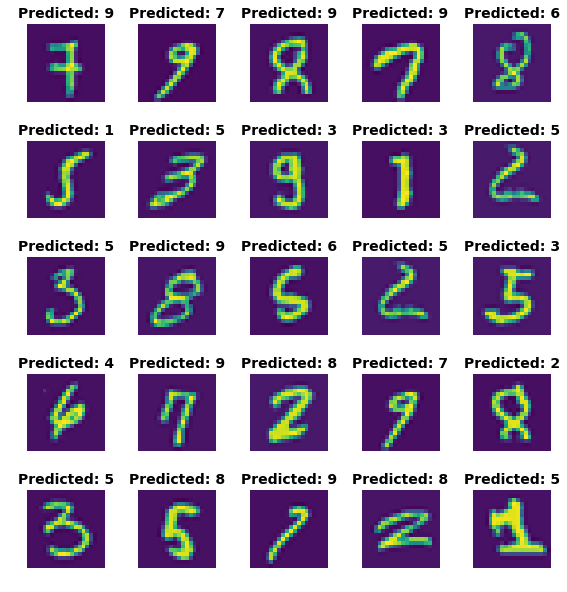

In [24]:
neg = pred.reshape(-1,1) != y.reshape(-1,1)
neg_indices = [i for i,x in enumerate(neg) if x]
#np.random.choice(neg_indices,2)

fig,axs = plt.subplots(n_rows,n_cols, figsize=(10,10))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i in range(n_cols*n_rows):
    sample = np.random.choice(neg_indices,1)
    a = data['X'][sample].reshape(-1,pix).T
    plt.imshow(a)
    def display_predict():
        predicted_val = pred[sample]
        if predicted_val != 10:
            return predicted_val
        else:
            return 0
    predicted_val = display_predict()
    axs[i].axis('off')
    axs[i].set_title('Predicted: %d'%predicted_val, fontsize=14, fontweight='bold')
    axs[i].imshow(a)

## Using Neural Networks 

Neural networks, as we have seen during the course of the lecture, have show improved accruacy in prediction.

In the practice below, we will import the weights of an already trained neural network model that classifies hand-written digits and we will try to make prediciton using these trained weights.

Notice that there are two arrays containing theta (weights), Thius signifies that the neural network has one hidden layer.

In [25]:
# Load the weight matrix
weights = loadmat('data/ex3weights.mat')
weights

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue Oct 18 14:57:02 2011',
 '__version__': '1.0',
 '__globals__': [],
 'Theta1': array([[-2.25623899e-02, -1.05624163e-08,  2.19414684e-09, ...,
         -1.30529929e-05, -5.04175101e-06,  2.80464449e-09],
        [-9.83811294e-02,  7.66168682e-09, -9.75873689e-09, ...,
         -5.60134007e-05,  2.00940969e-07,  3.54422854e-09],
        [ 1.16156052e-01, -8.77654466e-09,  8.16037764e-09, ...,
         -1.20951657e-04, -2.33669661e-06, -7.50668099e-09],
        ...,
        [-1.83220638e-01, -8.89272060e-09, -9.81968100e-09, ...,
          2.35311186e-05, -3.25484493e-06,  9.02499060e-09],
        [-7.02096331e-01,  3.05178374e-10,  2.56061008e-09, ...,
         -8.61759744e-04,  9.43449909e-05,  3.83761998e-09],
        [-3.50933229e-01,  8.85876862e-09, -6.57515140e-10, ...,
         -1.80365926e-06, -8.14464807e-06,  8.79454531e-09]]),
 'Theta2': array([[-0.76100352, -1.21244498, -0.10187131, -2.36850085, -1.057781

In [26]:
# Save the weights into variables 
theta1, theta2 = weights['Theta1'], weights['Theta2']

### Prediction

Lets see how well the model does at predicition

In [27]:
def predict(theta_1, theta_2, features):
    z2 = theta_1 @ features.T
    a2 = np.c_[np.ones((data['X'].shape[0],1)), sigmoid(z2).T]
    
    z3 = a2 @ theta_2.T
    a3 = sigmoid(z3)
        
    return(np.argmax(a3, axis=1)+1)

In [29]:
pred_nn = predict(theta1, theta2, X)
print('Training set accuracy: {} %'.format(np.mean(pred_nn == y.ravel())*100))

Training set accuracy: 97.52 %


Notice that we are able to achieve a higher prediciton accuracy

#### Lets see a sample of all the digits that where classified correctly

In [ ]:
n_cols = 5 
n_rows = 5
pix = 20
fig,axs = plt.subplots(n_rows,n_cols, figsize=(10,10))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i in range(n_cols*n_rows):
    sample = np.random.choice(X.shape[0],1)
    a = data['X'][sample].reshape(-1,pix).T
    plt.imshow(a)
    def display_predict():
        predicted_val = pred_nn[sample]
        if predicted_val != 10:
            return predicted_val
        else:
            return 0
    predicted_val = display_predict()
    axs[i].axis('off')
    axs[i].set_title('Predicted: %d'%predicted_val, fontsize=14, fontweight='bold')
    axs[i].imshow(a)

#### Lets see a sample of all the digits that where classified incorrectly

In [ ]:
neg = pred_nn.reshape(-1,1) != y.reshape(-1,1)
neg_indices = [i for i,x in enumerate(neg) if x]
#np.random.choice(neg_indices,2)

fig,axs = plt.subplots(n_rows,n_cols, figsize=(10,10))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i in range(n_cols*n_rows):
    sample = np.random.choice(neg_indices,1)
    a = data['X'][sample].reshape(-1,pix).T
    plt.imshow(a)
    def display_predict():
        predicted_val = pred_nn[sample]
        if predicted_val != 10:
            return predicted_val
        else:
            return 0
    predicted_val = display_predict()
    axs[i].axis('off')
    axs[i].set_title('Predicted: %d'%predicted_val, fontsize=14, fontweight='bold')
    axs[i].imshow(a)